In [1]:
#Libraries and settings.
from ipywidgets import interact, IntSlider
from matplotlib import animation
from sodapy import Socrata

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


cmap = cm.get_cmap('PuRd')

colors = [cmap(int(256*i/(4-1))) for i in range(4)]
c1, c2 = colors[2:]

months = 12
conversion = {
    'Gener': 1,
    'Febrer': 2,
    'Març': 3,
    'Abril': 4,
    'Maig': 5,
    'Juny': 6,
    'Juliol': 7,
    'Agost': 8,
    'Setembre': 9,
    'Octubre': 10,
    'Novembre': 11,
    'Desembre': 12
}
english_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December'
]

translation = {
    'Castellà': 'Spanish',
    'Català': 'Catalan',
    'Anglès': 'English',
    'Francès': 'French',
    'Rus': 'Russian',
    'Àrab': 'Arabic',
    'Italià': 'Italian',
    'Xinès': 'Chinese',
    'Romanès': 'Romanian',
    'Alemany': 'German',
    'No consta': 'Not provided'
}

first_year = 2013
final_year = 2020
num_years = (final_year-first_year) + 1

In [2]:
#We load the DataFrame.
client = Socrata("analisi.transparenciacatalunya.cat", None)

result1 = client.get("q2sg-894k", limit=150000)
result2 = client.get("6rcq-y46b", limit=300)

phone_calls = pd.DataFrame.from_records(result1)
real_cases = pd.DataFrame.from_records(result2)

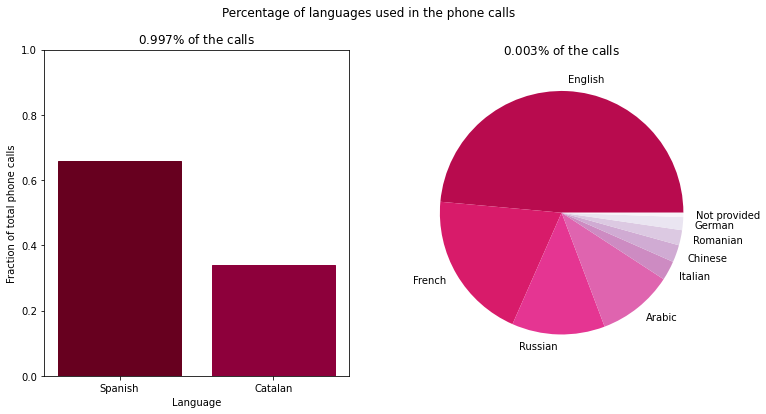

In [3]:
%matplotlib inline


#Simple example.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

language = phone_calls['llengua'].value_counts()
values = language.values / language.values.sum()
labels = [translation[lang] for lang in language.index]

n = len(values)
new_colors = [cmap(int(256*i/(n-1))) for i in range(n)][::-1]

fig.suptitle('Percentage of languages used in the phone calls')

#Bar plot.
bars = axs[0].bar(labels[:2], values[:2])
bars[0].set_color(new_colors[0])
bars[1].set_color(new_colors[1])

axs[0].set_title(f'${sum(values[:2]):.3f}\%$ of the calls')
axs[0].set_xlabel('Language')
axs[0].set_ylabel('Fraction of total phone calls')
axs[0].set_ylim(0, 1)

#Pie plot.
axs[1].pie(x=values[2:],
           labels=labels[2:],
           colors=new_colors[2:],
           normalize=True)

_ = axs[1].set_title(f'${sum(values[2:]):.3f}\%$ of the calls')

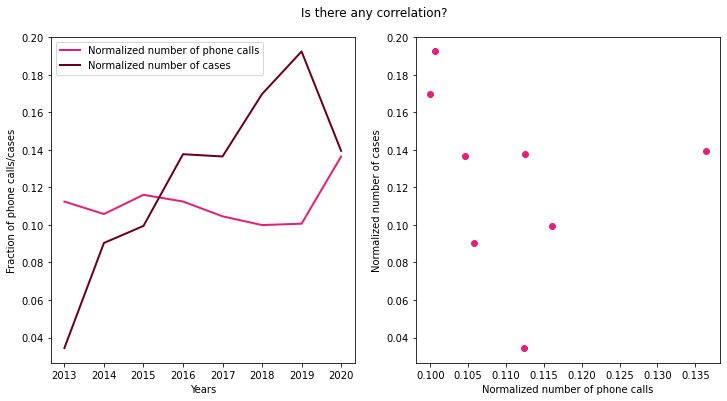

In [4]:
%matplotlib inline


series_calls = dict(phone_calls['any'].value_counts() / phone_calls['any'].value_counts().sum())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

years, number_cases, number_calls = [], [], []
for year in range(first_year, final_year+1):
    series_cases = real_cases[real_cases['any'] == str(year)]['v_ctimes_ateses']
    years.append(year)
    number_calls.append(series_calls[str(year)])
    number_cases.append(sum(map(int, series_cases.values)))
number_cases = [n/sum(number_cases) for n in number_cases]

axs[0].plot(years, number_calls, color=c1, lw=2, label='Normalized number of phone calls')
axs[0].plot(years, number_cases, color=c2, lw=2, label='Normalized number of cases')
axs[0].set_xlabel('Years')
axs[0].set_xticks(range(first_year, final_year+1))
axs[0].set_ylabel('Fraction of phone calls/cases')
axs[0].legend()

axs[1].scatter(number_calls, number_cases, color=c1, marker='o')
axs[1].set_xlabel('Normalized number of phone calls')
axs[1].set_ylabel('Normalized number of cases')

_ = fig.suptitle('Is there any correlation?', y=0.95)

In [5]:
%matplotlib inline

def main(final_year):
    first_year = 2013
    num_years = (final_year-first_year) + 1
    
    plt.grid(linewidth=0.1)
    
    square = np.zeros(months)
    cumulative = np.zeros(months)
    for year in range(first_year, final_year+1):
        series = phone_calls[phone_calls['any'] == str(year)]['mes'].value_counts()
        #I convert the name of each month to its associated value to sort them.
        series.index = [conversion[month] for month in series.index]
        series = series.sort_index()
        square += series.values**2
        cumulative += series.values
        
        plt.plot(series.index, series.values, linewidth=0.3, color=c1)
    square /= num_years
    cumulative /= num_years
    
    error = np.sqrt((square-cumulative**2)/num_years)
    
    plt.axhline(sum(cumulative)/len(cumulative), linestyle='--', color=c2)
    
    plt.fill_between(range(1, months+1),
                     cumulative-error,
                     cumulative+error,
                     color=c1,
                     alpha=0.2,
                     zorder=-1)
    
    plt.errorbar(range(1, months+1),
                 cumulative,
                 error,
                 elinewidth=2,
                 capsize=5,
                 marker='s',
                 markersize=8,
                 linewidth=3,
                 color=c1)
    
    plt.xticks(range(1, months+1), english_names, rotation=45)
    
    plt.xlabel('Month')
    plt.ylabel('Number of phone calls')


if __name__ == '__main__':
    interact(main, final_year=IntSlider(min=2013, max=2020, step=1, value=2013))

interactive(children=(IntSlider(value=2013, description='final_year', max=2020, min=2013), Output()), _dom_cla…

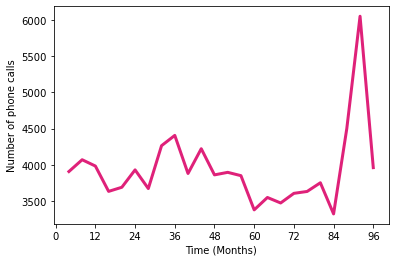

In [6]:
%matplotlib inline


x_temp, y_temp = [], []
for idx, year in enumerate(range(first_year, final_year+1)):
    series = phone_calls[phone_calls['any'] == str(year)]['mes'].value_counts()
    #I convert the name of each month to its associated value to sort them.
    series.index = [conversion[month] for month in series.index]
    series = series.sort_index()
    
    x_temp += list(series.index + 12*idx)
    y_temp += list(series.values)

x_data, y_data = [], []
for i in range(0, len(x_temp), 4):
    x_data.append(i+4)
    y_data.append(sum(y_temp[i:i+4]))

plt.xticks(range(0, 108+1, 12))
plt.ylabel('Number of phone calls')
plt.xlabel('Time (Months)')
plt.plot(x_data, y_data, color=c1, linewidth=3)
plt.show()

In [7]:
%matplotlib qt

FLAG = 0
def update_vbars(num, data):
    global FLAG
    if FLAG == 0 and num == 0:
        FLAG = 1
        return
    ax.text(data[num]-months/2, 6250, f'{num+2013}', horizontalalignment='center')
    if num < 8:
        ax.axvline(data[num], linestyle='--', linewidth=0.3, color=c1)

def update_lines(num, data_lines, lines):
    for line, data in zip(lines, data_lines):
        line.set_xdata([data[i][0] for i in range(num)])
        line.set_ydata([data[i][1] for i in range(num)])
    return lines


x_temp, y_temp = [], []
for idx, year in enumerate(range(first_year, final_year+1)):
    series = phone_calls[phone_calls['any'] == str(year)]['mes'].value_counts()
    #I convert the name of each month to its associated value to sort them.
    series.index = [conversion[month] for month in series.index]
    series = series.sort_index()
    
    x_temp += list(series.index + 12*idx)
    y_temp += list(series.values)

vbars = [12*i for i in range(1, num_years+1)]

fig, ax = plt.subplots()

ax.set_xlim(0, 108)
ax.set_xticks(range(0, 108+1, 12))
ax.set_xlabel('Time (Months)')

ax.set_ylim(2500, 6500)
ax.set_ylabel('Number of phone calls')

temp = []
for i in range(0, len(x_temp), 4):
    temp.append([i+4, sum(y_temp[i:i+4])])

lines = [ax.plot([point[0]], [point[1]], linewidth=3, color=c1)[0] for point in temp]

frame_rate = 300
ani2 = animation.FuncAnimation(fig,
                               update_vbars,
                               len(vbars),
                               fargs=([vbars]),
                               interval=3*frame_rate,
                               repeat=False)
ani1 = animation.FuncAnimation(fig,
                               update_lines,
                               len(temp)+1,
                               fargs=([temp], lines),
                               interval=frame_rate,
                               repeat=False)
plt.show()